<h1>Оглавление<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Описание-задачи" data-toc-modified-id="Описание-задачи-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Описание задачи</a></span></li><li><span><a href="#Рассмотрим-датасет-по-ближе" data-toc-modified-id="Рассмотрим-датасет-по-ближе-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Рассмотрим датасет по ближе</a></span></li><li><span><a href="#Выделим-выборки" data-toc-modified-id="Выделим-выборки-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выделим выборки</a></span></li><li><span><a href="#Обучение-модели" data-toc-modified-id="Обучение-модели-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Обучение модели</a></span></li><li><span><a href="#Оценка-точности" data-toc-modified-id="Оценка-точности-5"><span class="toc-item-num">5&nbsp;&nbsp;</span>Оценка точности</a></span></li></ul></div>

## Описание задачи

В связи с совершенствованием технологий геодезической съемки,
инновационным решением при диагностике, строительстве и эксплуатации
железнодорожных путей и придорожной инфраструктуры является
построение цифровых моделей пути (ЦМП) на основе данных лазерного
сканирования. Результат лазерного сканирования — это высокоточный
массив точек лазерных отражений (ТЛО), на основе которого проводятся
все необходимые измерения и последующий анализ данных. Определение
опор контактной сети (ОКС) в массиве ТЛО — это одна из обязательных
подзадач процесса определения габаритов приближения подвижного
состава к ОКС.

Участникам чемпионата предстоит создать свое решение по
прогнозированию класса ТЛО с использованием параметра этой точки.



Описание входных значений:

**train.csv** — файл, содержащий данные для тренировки. Структура датасета:
* Параметр «id» — уникальный идентификатор ТЛО.
* Параметр «Easting» — направление на восток, условная координата Х
ТЛО в метрах
* Параметр «Northing» — направление на север, условная координата У
ТЛО в метрах
* Параметр «Height» — отметка (высота), условная координата Н ТЛО в
метрах
* Параметр «Reflectance» — отражательная способность ТЛО
* Параметр «Class» — признак класса точки


**test.csv** - содержит данные ТЛО для предсказания


**sample_solution.csv** — пример файла для отправки


Пояснение к данным:

Столбец «Class» хранит в себе тип класса точки, где:
* `0` – точки земли
* `1` – точки опор
* `3` – точки растительности
* `4` – точки рельсов
* `5` – точки элементов контактной сети
* `64` – точки шумов

In [1]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 76.8 MB 1.8 MB/s 


In [2]:
!pip install phik

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 690 kB 4.9 MB/s 


In [4]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import time

import numpy as np
from sklearn.metrics import recall_score,  make_scorer
from catboost import CatBoostClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler, PolynomialFeatures
from phik import phik_matrix


%matplotlib inline

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [6]:
df_train = pd.read_csv("/content/drive/MyDrive/Novosib/train_dataset.csv")

In [7]:
df_test = pd.read_csv("/content/drive/MyDrive/Novosib/test_dataset.csv")

## Рассмотрим датасет по ближе

In [35]:
df_train.shape

(4222094, 6)

In [36]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4222094 entries, 0 to 4222093
Data columns (total 6 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   Easting      float64
 2   Northing     float64
 3   Height       float64
 4   Reflectance  float64
 5   Class        int64  
dtypes: float64(4), int64(2)
memory usage: 193.3 MB


In [37]:
df_train.head()

,id,Easting,Northing,Height,Reflectance,Class
0,2321251,431696.5375,6.032319e+06,69.2226,-11.14,0
1,3515173,431710.3835,6.032291e+06,68.9711,-15.16,3
2,2320295,431696.8099,6.032322e+06,69.2453,-13.59,0
3,2454459,431680.4542,6.032343e+06,69.1892,-11.21,0
4,4608150,431720.0914,6.032288e+06,67.3252,-9.10,0


Пострим на распределение данных

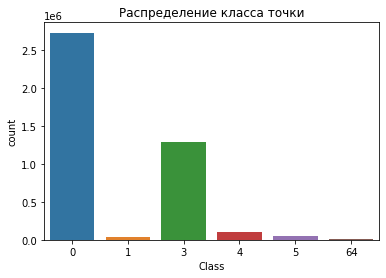

In [38]:
sns.countplot(x = "Class" , data  = df_train).set_title('Распределение класса точки');

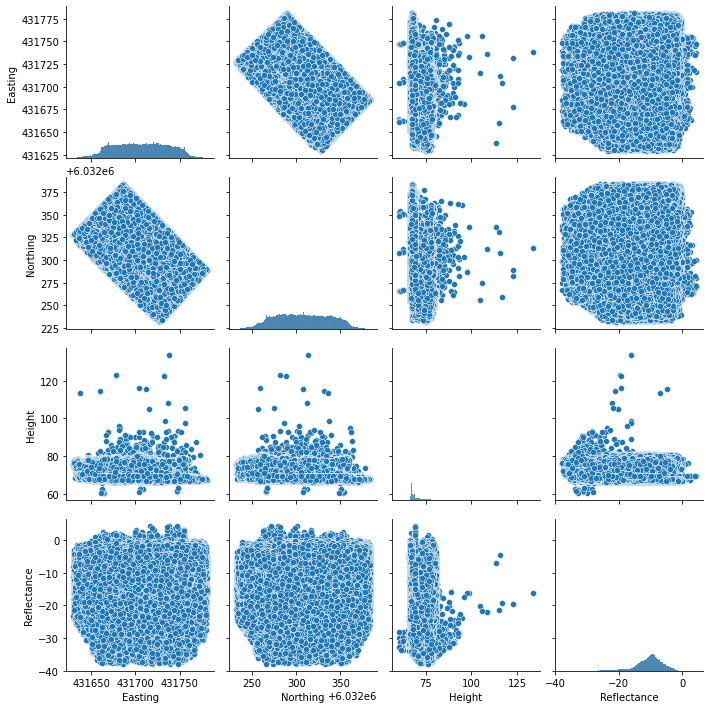

In [39]:
sns.pairplot(df_train[['Easting',	'Northing',	'Height',	'Reflectance']]);

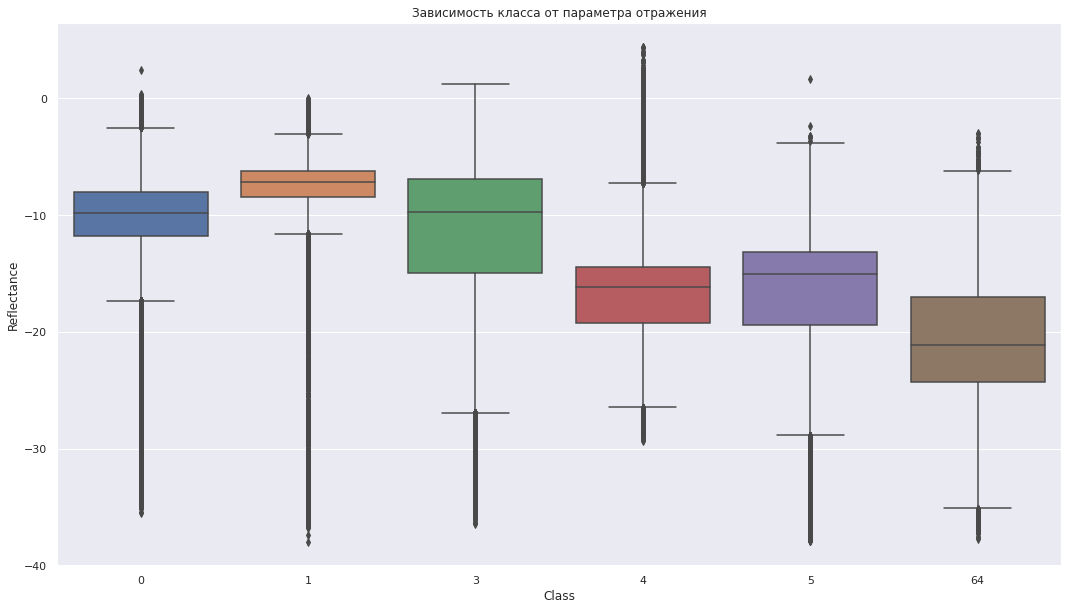

In [40]:
sns.set(rc={'figure.figsize':(18,10)})
sns.boxplot(data = df_train, x= "Class", y = "Reflectance").set_title('Зависимость класса от параметра отражения');

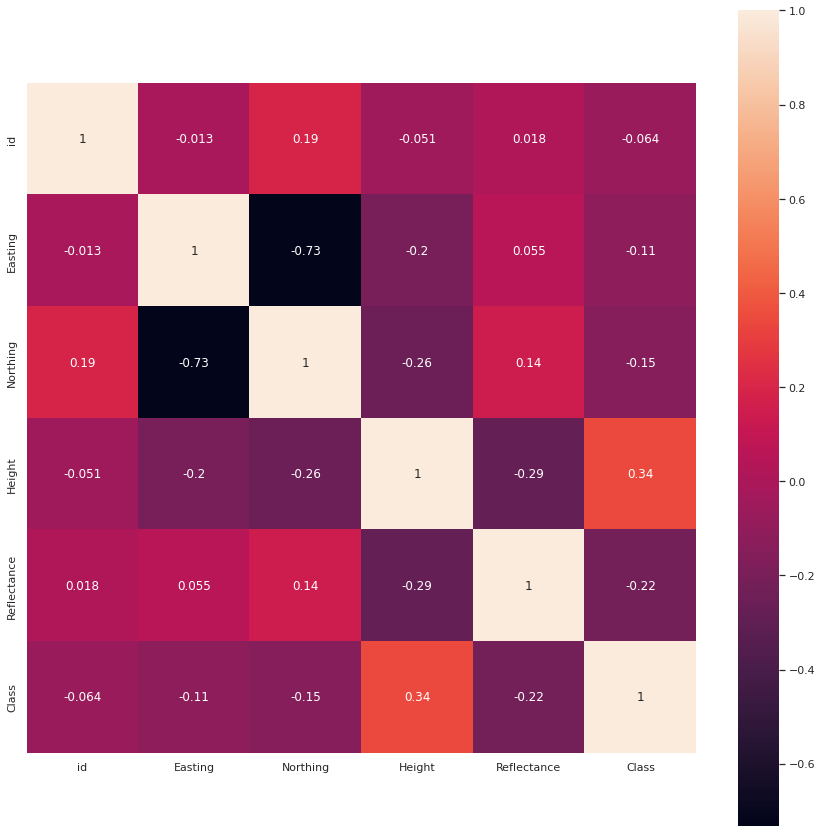

In [41]:
plt.rcParams['figure.figsize']=(15,15)

g = sns.heatmap(df_train.corr(), square = True, annot=True)

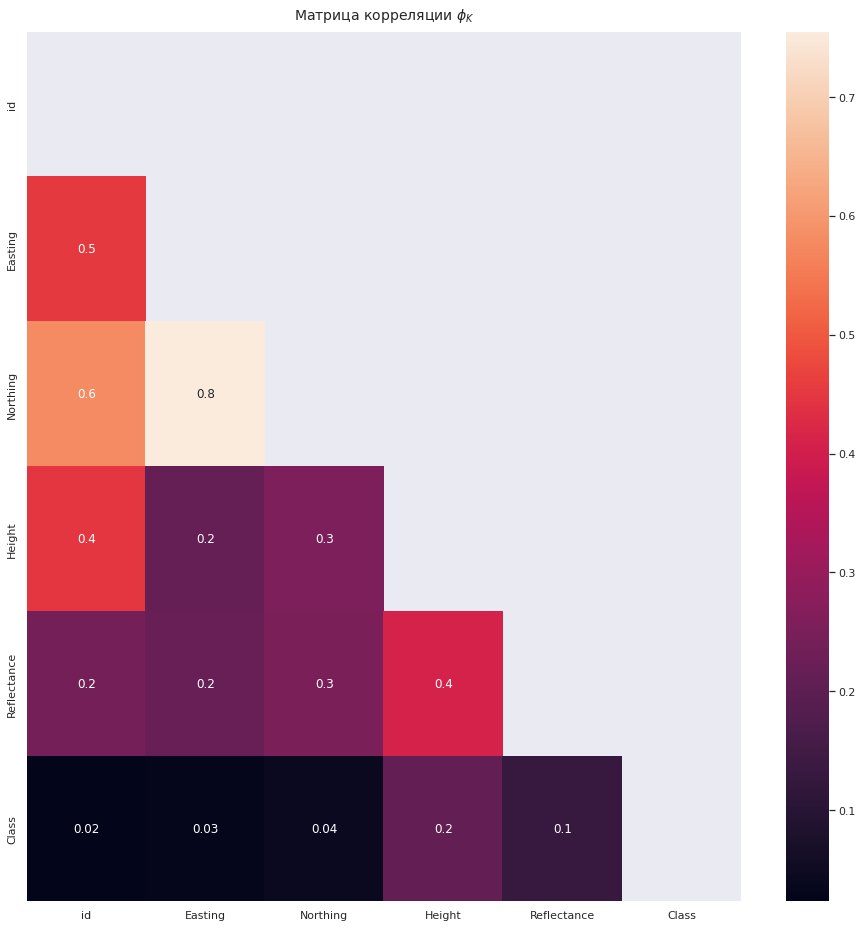

In [42]:
m = np.tri(len(df_train.columns),len(df_train.columns)).transpose()
heatmap = plt.figure(figsize=(16, 16))
matrix = df_train.phik_matrix(interval_cols=df_train.columns)
heatmap = sns.heatmap(matrix, annot=True, fmt='.1g', mask=m)
heatmap.set_title('Матрица корреляции $\phi_K$', fontdict={'fontsize':14}, pad=12);

In [43]:
df_train.isna().sum()

id             0
Easting        0
Northing       0
Height         0
Reflectance    0
Class          0
dtype: int64

## Выделим выборки

In [8]:
df_train = df_train.fillna(0)

In [9]:
X = df_train.drop(["Class", "id"], axis = 1)
y = df_train[["Class"]]

In [10]:
X.shape

(4222094, 4)

In [11]:
X.head()

,Easting,Northing,Height,Reflectance
0,431696.5375,6.032319e+06,69.2226,-11.14
1,431710.3835,6.032291e+06,68.9711,-15.16
2,431696.8099,6.032322e+06,69.2453,-13.59
3,431680.4542,6.032343e+06,69.1892,-11.21
4,431720.0914,6.032288e+06,67.3252,-9.10


In [12]:
scaler = StandardScaler()

In [13]:
X_scal = scaler.fit_transform(X)

In [14]:
poly_feat = PolynomialFeatures(degree=4)

In [15]:
X_poly = poly_feat.fit_transform(X_scal) 

## Обучение модели

In [16]:
recall = make_scorer(recall_score, average='macro')

In [33]:
catboost = CatBoostClassifier(task_type="GPU", verbose=False, auto_class_weights='Balanced', random_state=314, loss_function='MultiClass')

In [34]:
%%time
catboost.fit(X_poly,y)

CPU times: user 3min 27s, sys: 45.5 s, total: 4min 13s
Wall time: 3min 12s


In [44]:
pred_train = catboost.predict(X_poly)

In [45]:
result = recall_score(y, pred_train, average='macro', zero_division=True)
print("Recall score",result)

Recall score 0.9836056086663928


## Оценка точности

In [23]:
 df_test.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1809469 entries, 0 to 1809468
Data columns (total 5 columns):
 #   Column       Dtype  
---  ------       -----  
 0   id           int64  
 1   Easting      float64
 2   Northing     float64
 3   Height       float64
 4   Reflectance  float64
dtypes: float64(4), int64(1)
memory usage: 69.0 MB


In [24]:
df_test.isna().sum()

id             0
Easting        0
Northing       0
Height         0
Reflectance    0
dtype: int64

In [25]:
X_test = df_test.drop('id', axis = 1)

In [26]:
X_test_scal = scaler.transform(X_test)
X_test_scal_poly = poly_feat.transform(X_test_scal)

In [46]:
pred = catboost.predict(X_test_scal_poly)

In [28]:
df_solution = pd.read_csv('/content/drive/MyDrive/Novosib/sample_solution.csv')

In [29]:
df_solution.head()

,id,Class
0,1836965,0
1,3659389,0
2,5433033,0
3,1168709,0
4,5821779,0


In [47]:
df_solution['Class'] = pred

In [48]:
df_solution.head()

,id,Class
0,1836965,0
1,3659389,3
2,5433033,0
3,1168709,3
4,5821779,3


In [49]:
df_solution.to_csv('/content/drive/MyDrive/Novosib/novosib_08_10_solution_scal_poly_7.csv', index=False)